# Youtube Prediction - Base Model

We have already performed EDA of this dataset.
Here, we will be building our base model.

Conclusions drawn from the EDA:
   1. Spread of bool features in test and train sets are similar
   2. CategoryIds 15 and 29 are not present in test set. These are extras in training dataset
   3. Train set have videos published in all the months as against the test set where the cideos have been taken from Nov and Dec only
   4. Majority of the videos have been published in the evening and the least in the morning. The trend is same in both test and train set
   5. Using heatmap we found that the description and duration_seconds have missing values
   6. Plotted correlation matrix to find that the target is least dependent on the binary features
   
Steps:
   1. Dropping columns which are not present in test set
   2. Extracting date, time and day of week information from publishedAt feature
   3. Categorizing time to different slots
   4. Encoding variables variabels
   5. LabelEncoding categorical variables
   6. Handling Missing Values
   7. Scale Numerical Features
   8. Modelling
   9. Comparing the performance of different models

# Import Libraries

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

%matplotlib inline

In [119]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [120]:
train_df.drop(['view_count', 'likes', 'dislikes', 'comment_count'], axis=1, inplace=True)
train_df.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523


In [121]:
test_df.drop('isTest', axis=1, inplace=True)
test_df.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail
0,_wNsZEqpKUA,"Billie Eilish: Same Interview, The Fifth Year ...",2021-11-30 17:00:10+00:00,UCIsbLox_y9dCIMLd8tdC6qg,Vanity Fair,24,2021-12-01,billie|billie eilish|billie eilish 2021|billie...,https://i.ytimg.com/vi/_wNsZEqpKUA/default.jpg,False,False,I'm so much more open to stuff now. On the ver...,_wNsZEqpKUA_2021-12-01,1335.0,True
1,2jfbXZiE6Lc,Redneck vs Fancy Whiskey Glass,2021-11-29 21:30:27+00:00,UCT_QEGH0myu6lgbE_biQPuw,Drew Talbert,23,2021-12-01,[None],https://i.ytimg.com/vi/2jfbXZiE6Lc/default.jpg,False,False,I’m just shocked Brad was able to sell him in ...,2jfbXZiE6Lc_2021-12-01,28.0,True
2,F1Hq8eVOMHs,Is Meat Really that Bad?,2021-11-30 15:01:34+00:00,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a Nutshell,27,2021-12-01,[None],https://i.ytimg.com/vi/F1Hq8eVOMHs/default.jpg,False,False,"The first 1,000 people to use this link will g...",F1Hq8eVOMHs_2021-12-01,728.0,True


# Removing video_id and thumbnail_link

In [122]:
train_df.drop(['video_id', 'thumbnail_link', 'id'], axis=1, inplace=True)
test_df.drop(['video_id', 'thumbnail_link'], axis=1, inplace=True)

# Extracting Date info from publishedAt

In [123]:
train_df['date'] = pd.to_datetime(train_df['publishedAt']).dt.month
train_df['time'] = pd.to_datetime(train_df['publishedAt']).dt.time
train_df['dayofweek'] = (train_df['publishedAt']).dt.dayofweek
train_df['trending_date'] = pd.to_datetime(train_df['publishedAt']).dt.month
train_df['monthsold'] = train_df['trending_date'] - train_df['date']

In [124]:
test_df['date'] = pd.to_datetime(test_df['publishedAt']).dt.month
test_df['time'] = pd.to_datetime(test_df['publishedAt']).dt.time
test_df['dayofweek'] = (test_df['publishedAt']).dt.dayofweek
test_df['trending_date'] = pd.to_datetime(test_df['publishedAt']).dt.month
test_df['monthsold'] = test_df['trending_date'] - test_df['date']

In [125]:
test_df['monthsold'].value_counts()

0    5800
Name: monthsold, dtype: int64

In [126]:
train_df['monthsold'].value_counts()

0    92275
Name: monthsold, dtype: int64

### We see that the prediction was made in the same month of publishing, we can drop the trending date for the time being

In [65]:
train_df.drop(['monthsold', 'trending_date'], axis=1, inplace=True)
test_df.drop(['monthsold', 'trending_date'], axis=1, inplace=True)

### Binning time to timeofday

Categorizing the time into 6 groups:
1. Late Night
2. Early Morning
3. Morning
4. Noon
5. Evening 
6. Night

In [127]:
train_df['time'] = pd.to_datetime(train_df['publishedAt']).dt.hour
test_df['time'] = pd.to_datetime(test_df['publishedAt']).dt.hour

In [128]:
time = 'time'

def timeofday(df):
    df[time] = (df[time] % 24 + 4) // 4
    df[time].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [129]:
timeofday(train_df)
timeofday(test_df)

## Encoding

In [130]:
bool_features = [i for i in train_df.columns if train_df[i].dtypes == 'bool']

In [131]:
bool_features

['comments_disabled', 'ratings_disabled', 'has_thumbnail']

In [132]:
def bool_encode(df):
    for i in bool_features:
        df[i] = df[i].astype(int)

In [133]:
bool_encode(train_df)
bool_encode(test_df)

In [134]:
train_df.head(3)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,comments_disabled,ratings_disabled,description,duration_seconds,has_thumbnail,target,date,time,dayofweek,monthsold
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,8,brawadis|prank|basketball|skits|ghost|funny vi...,0,0,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,NaN,1,0.103596,8,Evening,1,0
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,8,Apex Legends|Apex Legends characters|new Apex ...,0,0,"While running her own modding shop, Ramya Pare...",NaN,1,0.061611,8,Evening,1,0
2,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,8,jacksepticeye|funny|funny meme|memes|jacksepti...,0,0,I left youtube for a month and this is what ha...,NaN,1,0.173523,8,Evening,1,0


In [135]:
train_df['tags'] = train_df['tags'].apply(lambda x: x[:100])              #considering only first 100 characters 

In [137]:
train_df['tags'][0]

'brawadis|prank|basketball|skits|ghost|funny videos|vlog|vlogging|NBA|browadis|challenges|bmw i8|faze'

# publishedAt is no longer required

In [138]:
train_df.drop('publishedAt', axis=1, inplace=True)
test_df.drop('publishedAt', axis=1, inplace=True)

In [139]:
feature_list = ['channelTitle', 'channelId', 'title', 'description', 'tags']

# For non-binary categorical features
def feature_engg(df):
    '''
        Extracting columns with the value counts mapped to their categories for each of the features in feature list
        df: DataFrame to be considered
    '''
    for i in feature_list:
        frequencies=df[i].value_counts()
        mapping=df[i].map(frequencies)
        df[str(i)+'Top']=df[i].mask(mapping<6,'Other')

In [140]:
feature_engg(train_df)
feature_engg(test_df)

In [141]:
train_df.head(3)

,title,channelId,channelTitle,categoryId,trending_date,tags,comments_disabled,ratings_disabled,description,duration_seconds,...,target,date,time,dayofweek,monthsold,channelTitleTop,channelIdTop,titleTop,descriptionTop,tagsTop
0,I ASKED HER TO BE MY GIRLFRIEND...,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,8,brawadis|prank|basketball|skits|ghost|funny vi...,0,0,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,NaN,...,0.103596,8,Evening,1,0,Brawadis,UCvtRTOMP2TqYqu51xNrqAzg,I ASKED HER TO BE MY GIRLFRIEND...,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,brawadis|prank|basketball|skits|ghost|funny vi...
1,Apex Legends | Stories from the Outlands – “Th...,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,8,Apex Legends|Apex Legends characters|new Apex ...,0,0,"While running her own modding shop, Ramya Pare...",NaN,...,0.061611,8,Evening,1,0,Apex Legends,UC0ZV6M2THA81QT9hrVWJG3A,Other,Other,Apex Legends|Apex Legends characters|new Apex ...
2,I left youtube for a month and THIS is what ha...,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,8,jacksepticeye|funny|funny meme|memes|jacksepti...,0,0,I left youtube for a month and this is what ha...,NaN,...,0.173523,8,Evening,1,0,jacksepticeye,UCYzPXprvl5Y-Sf0g4vX-m6g,I left youtube for a month and THIS is what ha...,I left youtube for a month and this is what ha...,jacksepticeye|funny|funny meme|memes|jacksepti...


### Label Encoding 

In [142]:
from sklearn.preprocessing import LabelEncoder

def LE(train, test):
    le = LabelEncoder()
    for col in train.columns:
        if train[col].dtypes == 'object':
            train[col] = le.fit_transform(train[col])
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            test[col] = test[col].apply(lambda x: le_dict.get(x, -1))
    return train, test

train, test = LE(train_df, test_df)

In [143]:
train.head()

,title,channelId,channelTitle,categoryId,trending_date,tags,comments_disabled,ratings_disabled,description,duration_seconds,...,target,date,time,dayofweek,monthsold,channelTitleTop,channelIdTop,titleTop,descriptionTop,tagsTop
0,6257,4292,524,22,8,5406,0,0,10635,NaN,...,0.103596,8,1,1,0,351,2989,2896,4460,2729
1,1254,109,250,20,8,450,0,0,15981,NaN,...,0.061611,8,1,1,0,163,80,5038,4035,223
2,6974,2599,4472,24,8,7299,0,0,5732,NaN,...,0.173523,8,1,1,0,3113,1793,3254,2420,3756
3,16378,2871,4251,10,8,10508,0,0,11800,NaN,...,0.046804,8,1,1,0,2970,1978,5038,4035,1700
4,15190,1062,2631,26,8,4248,0,0,14405,NaN,...,0.040753,8,5,1,0,1819,717,6981,5993,2147


In [144]:
train.drop(['title', 'channelId', 'channelTitle', 'description', 'tags'], axis=1, inplace=True)
test.drop(['title', 'channelId', 'channelTitle', 'description', 'tags'], axis=1, inplace=True)

# Handling missing values

In [145]:
# Replacing missing values with median

train['duration_seconds'] = train['duration_seconds'].fillna(train['duration_seconds'].median())
test['duration_seconds'] = test['duration_seconds'].fillna(test['duration_seconds'].median())

In [146]:
train.head(3)

,categoryId,trending_date,comments_disabled,ratings_disabled,duration_seconds,has_thumbnail,target,date,time,dayofweek,monthsold,channelTitleTop,channelIdTop,titleTop,descriptionTop,tagsTop
0,22,8,0,0,446.0,1,0.103596,8,1,1,0,351,2989,2896,4460,2729
1,20,8,0,0,446.0,1,0.061611,8,1,1,0,163,80,5038,4035,223
2,24,8,0,0,446.0,1,0.173523,8,1,1,0,3113,1793,3254,2420,3756


In [147]:
test.head(3)

,categoryId,trending_date,comments_disabled,ratings_disabled,id,duration_seconds,has_thumbnail,date,time,dayofweek,monthsold,channelTitleTop,channelIdTop,titleTop,descriptionTop,tagsTop
0,24,11,0,0,_wNsZEqpKUA_2021-12-01,1335.0,1,11,1,1,0,2877,973,-1,-1,-1
1,23,11,0,0,2jfbXZiE6Lc_2021-12-01,28.0,1,11,4,0,0,-1,-1,5038,4035,2376
2,27,11,0,0,F1Hq8eVOMHs_2021-12-01,728.0,1,11,5,1,0,1478,2818,5038,4035,2376


# Scale Numerical Features

In [148]:
num_features = [i for i in train.columns if train[i].dtypes == 'int64' or train[i].dtypes == 'int32' or train[i].dtypes == float]

In [149]:
num_features.remove('target')

In [150]:
scaler = StandardScaler()

train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [151]:
train.head(3)

,categoryId,trending_date,comments_disabled,ratings_disabled,duration_seconds,has_thumbnail,target,date,time,dayofweek,monthsold,channelTitleTop,channelIdTop,titleTop,descriptionTop,tagsTop
0,0.475737,0.218892,-0.128416,-0.069534,-0.053444,0.376871,0.103596,0.218892,-0.871674,-0.948105,0.0,-1.441281,1.542997,-0.825316,0.335214,0.181618
1,0.184462,0.218892,-0.128416,-0.069534,-0.053444,0.376871,0.061611,0.218892,-0.871674,-0.948105,0.0,-1.649058,-1.437871,0.338524,0.081844,-1.713501
2,0.767012,0.218892,-0.128416,-0.069534,-0.053444,0.376871,0.173523,0.218892,-0.871674,-0.948105,0.0,1.611262,0.317450,-0.630800,-0.880960,0.958269


# Modeling

In [152]:
x = train.drop(['target'], axis=1)
y = train['target']

In [153]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [154]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [155]:
def model_performance(y_pred, original_col, fitted_col, txt):
    '''
    This is to visualize the model performance.
    Parameters: 
    y_pred - Series of the predicted values
    original_col - Color of the actual value line
    fitted_col - color of the predicted value line
    '''
    plt.figure(figsize=(5,5))
    ax1 = sns.distplot(y_test, hist=False, color=original_col, label='Actual Value')
    sns.distplot(y_pred, hist=False, color=fitted_col, label='Predicted Value', ax=ax1)
    plt.title(txt, fontsize=20)

In [156]:
def model_score(model, txt):
    '''
    Printing all the performance metrics:
    R2 Square, Mean Absolute, Mean Squared Error, Root Mean Squared Error
    
    Parameters:
    model: Trained Model
    txt: To print the results for each model
    '''
    #Predicting the SalePrices using test set 
    y_pred = model.predict(x_test)
    mae=metrics.mean_absolute_error(y_test, y_pred)
    mse=metrics.mean_squared_error(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    # Printing the metrics
    print(txt, model.score(x_test,y_test))
    print('R2 square:',metrics.r2_score(y_test, y_pred))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    
    return y_pred

# Random Forest

In [157]:
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(x_train,y_train)

rf_y_pred = model_score(rf_regressor, 'Random Forest Scores: ')

Random Forest Scores:  0.8760706927021528
R2 square: 0.8760706927021528
MAE:  0.007323375173510424
MSE:  0.00020489238006436242
RMSE:  0.01431406231872568


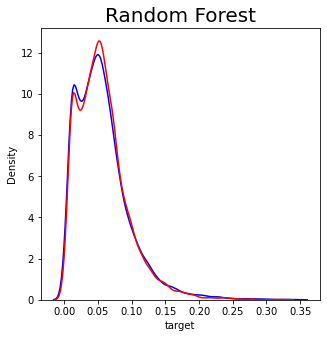

In [158]:
model_performance(rf_y_pred, 'b', 'r', 'Random Forest')

# XGB Regressor

In [97]:
params = { 'max_depth': range(3,11,1),
           'learning_rate': np.arange(0.01,0.1,0.1),
           'n_estimators': np.arange(100,1000,100),
           'colsample_bytree': np.arange(0.3, 0.7,0.1)}

xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                   cv=3,
                   param_distributions=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1,n_jobs=-1)
clf.fit(x_train,y_train)
print("Best parameters:", clf.best_params_)
print("Lowest mean squared wrr: ", (clf.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001}
Lowest mean squared wrr:  -0.02443639872960775


In [108]:
xgb = XGBRegressor( n_estimators = 600 , max_depth=10, learning_rate=0.01, random_state = 0)
xgb.fit(x_train,y_train)

xgb_y_pred = model_score(xgb, 'XGB Regression Scores: ')

XGB Regression Scores:  0.639856828786354
R2 square: 0.639856828786354
MAE:  0.0167928478739647
MSE:  0.0005954248686030774
RMSE:  0.024401329238446772


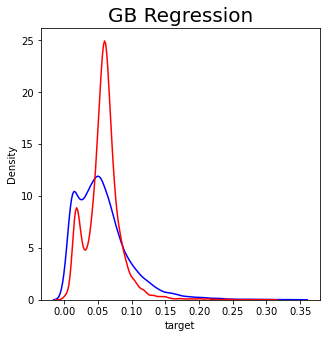

In [109]:
model_performance(xgb_y_pred, 'b', 'r', 'XGB Regression')

# Light GBM

In [105]:
import lightgbm as lgb
params = { 'max_depth': range(3,11,1),
           'learning_rate': np.arange(0.01,0.1,0.1),
           'n_estimators': np.arange(100,1000,100),
           'colsample_bytree': np.arange(0.3, 0.7,0.1)}

xgbr = lgb.LGBMRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                   cv=3,
                   param_distributions=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1,n_jobs=-1)
clf.fit(x_train,y_train)
print("Best parameters:", clf.best_params_)
print("Lowest mean squared wrr: ", (clf.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001}
Lowest mean squared wrr:  -0.029423335352143514


In [159]:
import lightgbm as lgb
lgb= lgb.LGBMRegressor(n_estimators = 900 , max_depth=8, learning_rate=0.01, importance_type='gain')
lgb.fit(x_train,y_train)

lgbm_y_pred = model_score(lgb, 'LGBM Regression Scores: ')

LGBM Regression Scores:  0.4761754548944309
R2 square: 0.4761754548944309
MAE:  0.020519598300485647
MSE:  0.0008660393584292742
RMSE:  0.029428546658461986


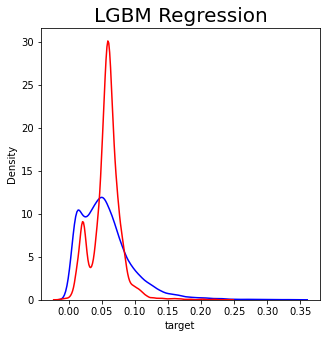

In [107]:
model_performance(lgbm_y_pred, 'b', 'r', 'LGBM Regression')

# Preparing the submission file

In [115]:
test1 = test.drop('id', axis=1)
submission = xgb.predict(test1)              # Predict with the best model
submission                                   # This contains our predicted values 

array([0.0628309 , 0.07739081, 0.06805672, ..., 0.0494469 , 0.03776241,
       0.0478877 ])

In [116]:
# Formatting to create a submission csv file with just the id and target

submit = pd.DataFrame()
submit['id'] = test['id']
submit['target'] = submission
submit

,id,target
0,_wNsZEqpKUA_2021-12-01,0.062831
1,2jfbXZiE6Lc_2021-12-01,0.077391
2,F1Hq8eVOMHs_2021-12-01,0.068057
3,GQXVQmcGQUY_2021-12-01,0.078371
4,n4XojTb6pfs_2021-12-01,0.083097
...,...,...
5795,hJfpCXAMYPM_2021-12-30,0.052552
5796,MbmTMEYnEzo_2021-12-30,0.063445
5797,VG7arSAYvQI_2021-12-30,0.049447
5798,SNb-g-hNYYs_2021-12-30,0.037762


In [117]:
submit.to_csv('submission13.csv', index=False)         # save as csv

# Save the model

In [161]:
import joblib

# Save the model as a pickle in a file
joblib.dump(xgb, 'xgb_YT_model.pkl')

['xgb_YT_model.pkl']

# Conclusions

There were very few missing data! The publishedAt had a lot of information. We extracted month, timeofday from it for model training. 
The model comparison tells us that the Random Forest overfitted the train data. Among the rest, the XGB Regressor did better (though a lot of improvement is needed).

As the next steps:
   1. We can try using different imputation techniques
   2. Try different encoding 
   3. Tune hyperparameters for Randon Forest and compare the results

### This model yeilded a score of 0.02416 (MAE score) on Kaggle submission